# TP 4: Improve the Metropolis-Hastings algorithm

**Author: Theau Blanchard**

In [1]:
import numpy as np
from scipy.stats import norm, invgamma
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set()

# Exercise 1

## 1.A – Metropolis-Hastings within Gibbs sampler


### Question 1

In [2]:
def log_pi(z,a=10):
    x,y = z
    return (-x**2/a**2 - y**2 - 1/4*(x**2/a**2-y**2)**2)

def pi(z,a=10):
    return np.exp(log_pi(z,a))

In [3]:
def compute_contour(rv,xmin, xmax, ymin, ymax, n_points=200):
    x = np.array(np.meshgrid(np.linspace(xmin, xmax, n_points), np.linspace(ymin, ymax, n_points)))
    x = x.reshape(2, n_points*n_points)
    z = np.zeros(n_points*n_points)
    for i in range(n_points*n_points):
        z[i] = rv(x[:,i])
    x = x.reshape(2, n_points, n_points)
    z = z.reshape(n_points, n_points)
    
    return x, z

def plot_distrib(X_ech,Z_ech,distib,title="",range_values = None,levels=None, n_points = 200, marker_size=5,box = None):
    nb_cluster = len(distib)
    fig = plt.figure()
    ax = plt.gca()
    if X_ech is not None :
        sns.scatterplot(data=pd.DataFrame(X_ech),x=0,y=1,hue=Z_ech,style=Z_ech,s=marker_size)
    if range_values is None and X_ech is not None :
        xmin, xmax = X_ech[:,0].min(), X_ech[:,0].max()
        ymin, ymax = X_ech[:,1].min(), X_ech[:,1].max()
    else :
        xmin, xmax, ymin, ymax = range_values
    for j in range(nb_cluster):
        x, z = compute_contour(distib[j],xmin, xmax, ymin, ymax, n_points=n_points)
        ax.contour(x[0], x[1], z,levels = levels)
    if box :
        ax.set_box_aspect(box)
    ax.set_title(title)

def crosscorr(x,y,max_lag=None):
    if max_lag is None:
        max_lag=len(x)
    sx=pd.Series(x)
    sy=pd.Series(y)
    res=np.zeros(max_lag)
    for lag in range(1,max_lag):
        res[lag]=sx.corr(sy.shift(lag))
    res[0]=1
    return res

In [4]:
def P_i(z0,i,pi_fun,sigma_prop,maxiter=1000,verbose=False):
    ''' 
    Hastings-Metropolis sampler

    Parameters
    ----------
    z0 : array of shape (2,), initial value of the Markov chain (here b = 2+2N)
    i : int, index of the variable to update
    pi_fun : function, log density
    sigma_prop : float, standard deviation of the proposal distribution
    maxiter : int, number of iterations
    verbose : bool, print acceptance rate

    Returns
    -------
    z_list : list of arrays, accepted values of the Markov chain
    '''

    #Initialisation
    z = z0

    z_list = [z0]

    #Loop
    for k in range(maxiter):
        #Proposal
        z_prop = z.copy()
        z_prop[i] += norm.rvs(loc=0, scale=sigma_prop, size=1)

        #Acceptance probability
        log_ratio = min(0,pi_fun(z_prop) - pi_fun(z))

        #Acceptance
        if np.log(np.random.rand()) < log_ratio:
            z = z_prop

            z_list.append(z)

    if verbose:
        print("Acceptance rate: ", len(z_list)/maxiter)
    
    if len(z_list) == 1:
        print("Warning : no point accepted, decrease sigma_prop")

    return z_list, len(z_list)/maxiter

In [5]:
def P(z0,pi_fun,sigma_props,maxiter_intra,num_points,verbose=False):
    '''
    Metropolis-Hastings sampler within Gibbs sampler.
    We update the first variable, then the second.

    Parameters
    ----------
    z0 : array of shape (2,), initial value of the Markov chain (here b = 2+2N)
    pi_fun : function, log density
    sigma_props : list of floats, standard deviations of the proposal distributions
    maxiter_intra : int, number of iterations within Gibbs sampler
    num_points : int, number of points to sample
    verbose : bool, print acceptance rate

    Returns
    -------
    z_list : list of arrays, accepted values of the Markov chain
    '''
    z_list = []

    accpt_rate_list_1 = []
    accpt_rate_list_2 = []

    for k in range(num_points):
        z_init = z0 if k == 0 else z_list[-1]
        z_0, accpt_rate1 = P_i(z_init,0,pi_fun,sigma_props[0],maxiter_intra,verbose)
        z_1, accpt_rate2 = P_i(z_0[-1],1,pi_fun,sigma_props[1],maxiter_intra,verbose)
        z_list.append(z_1[-1])
        accpt_rate_list_1.append(accpt_rate1)
        accpt_rate_list_2.append(accpt_rate2)

    return np.array(z_list), np.array(accpt_rate_list_1), np.array(accpt_rate_list_2)

### Question 2

Given that the distribution is anysotropic, the $\sigma_i$ values need to be different to accomodate for this. If we set both $\sigma_1$ and $\sigma_2$ to the same value, the acceptance rate will be much higher for the first variable than for the second one, around 87% for the first variable and 27% for the second one. This is because the first variable is much more likely to be accepted than the second one, which is not what we want. We want the acceptance rate to be similar for both variables.

In [6]:
z0 = np.random.rand(2)
sigma_props = [3.,3.]
maxiter = 100

z_list,accpt_1,accpt_2 = P(z0,log_pi,sigma_props,num_points=1000,maxiter_intra = 100,verbose=False)

Acceptance rate for the first variable :  0.87161
Acceptance rate for the second variable :  0.27043000000000006


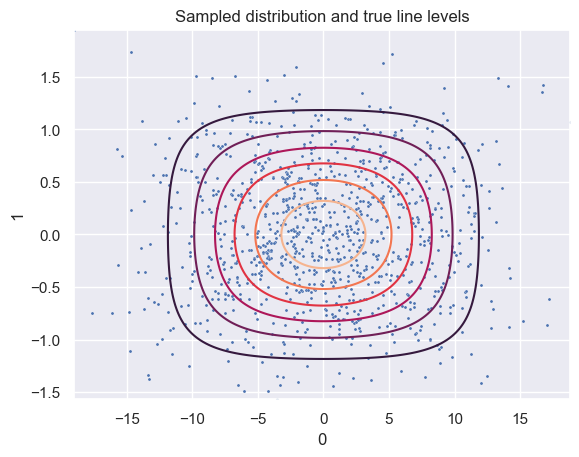

In [7]:
print("Acceptance rate for the first variable : ",accpt_1.mean())
print("Acceptance rate for the second variable : ",accpt_2.mean())
plot_distrib(np.array(z_list),None,[pi],title="Sampled distribution and true line levels")

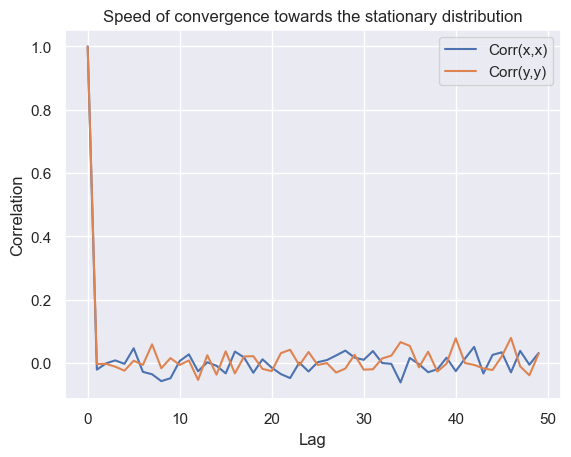

In [8]:
plt.plot(crosscorr(z_list[:,0],z_list[:,0],max_lag=50),label='Corr(x,x)')
plt.plot(crosscorr(z_list[:,1],z_list[:,1],max_lag=50),label='Corr(y,y)')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title("Speed of convergence towards the stationary distribution")
plt.legend()
plt.show()

### Question 3
To improve the performance of this algorithm we need to fine-tune the choosen values of $\sigma$ independently for both dimensions.
- We could use a fixed value for $\sigma$ and tune it manually to get a good acceptance rate. One could search such values by hand with a grid search
- Or we could try to update the value on the fly by linking it to current acceptance rate. For example, if the acceptance rate is too low, we could increase $\sigma$ and if it is too high, we could decrease it.

## 1.B – Adaptive Metropolis-Hastings within Gibbs sampler


### Question 1

In [9]:
def adaptative_MCMC_w_Gibbs(x_0,pi_fun,delta_fun,maxiter,threshhold=0.24,batch_size = 50):
    """ 
    Adaptative Metropolis-Hastings within Gibbs sampler

    Parameters
    ----------
    x_0 : array of shape (d,), initial value of the Markov chain
    pi_fun : function, log density
    maxiter : int, number of iterations, upper bound on the number of accepted points
    threshhold : float, acceptance rate threshold
    batch_size : int, number of iterations between two acceptance rate computations
    delta_fun : function, adaptation function

    Returns
    -------
    x_list : list of arrays, accepted values of the Markov chain
    """

    x_k = np.copy(x_0)
    x_list = [x_k]
    l = np.zeros(x_0.shape[0])


    acceptanced_samples = np.zeros(len(x_0))
    accept_rate = np.zeros((maxiter//50, x_0.shape[0]))
    l_list = [l]

    for j in range(maxiter):
        for i in range(len(x_k)):
            #Proposal
            x_prop = x_k.copy()
            prop = norm.rvs(loc=0, scale=np.exp(l[i]), size=1)
            x_prop[i] += prop

            #Acceptance probability
            log_ratio = min(0,pi_fun(x_prop) - pi_fun(x_k))

            #Acceptance
            if np.log(np.random.rand()) < log_ratio:
                x_k = x_prop
                x_list.append(x_k)
                acceptanced_samples[i] += 1

        #Adaptation
        if j%batch_size == 0 and j>0:
            accept_rate[j//batch_size] = acceptanced_samples/(j)
            delta_j = delta_fun(j)
            l = np.where(accept_rate[j//batch_size] > threshhold, l + delta_j, l - delta_j)
            # acceptanced_samples = np.zeros(len(x_0))
            
            l_list.append(l)

    return np.array(x_list), np.array(accept_rate), np.array(l_list)


#### On the first distribution

In [10]:
z0 = np.random.rand(2)

def delta_fun(j):
    return min(0.1, 1/np.sqrt(j))

x_list, accept_rate, l_list = adaptative_MCMC_w_Gibbs(z0,log_pi,delta_fun,maxiter=50000)

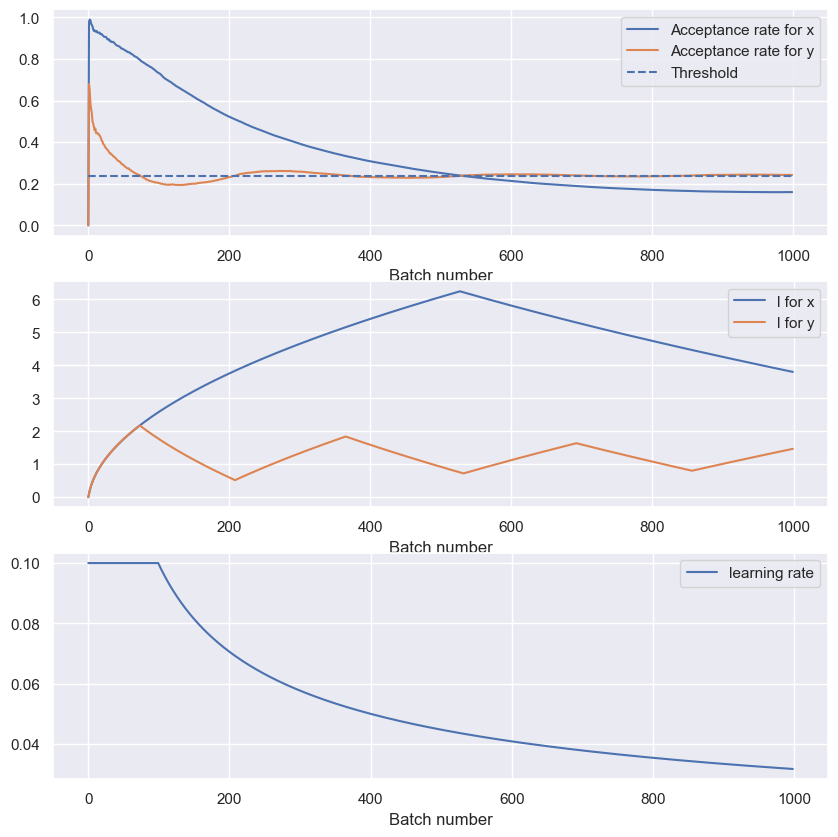

In [11]:
fig, axes = plt.subplots(3,1,figsize=(10,10))

axes[0].plot(accept_rate[:,0],label='Acceptance rate for x')
axes[0].plot(accept_rate[:,1],label='Acceptance rate for y')
axes[0].hlines(0.24,0,accept_rate.shape[0],linestyles='dashed',label='Threshold')
axes[0].legend()
axes[0].set_xlabel('Batch number')

axes[1].plot((l_list[:,0]),label='l for x')
axes[1].plot((l_list[:,1]),label='l for y')
axes[1].legend()
axes[1].set_xlabel('Batch number')

axes[2].plot([delta_fun(j) for j in range(1,len(accept_rate))],label='learning rate')
axes[2].legend()
axes[2].set_xlabel('Batch number')

plt.show()

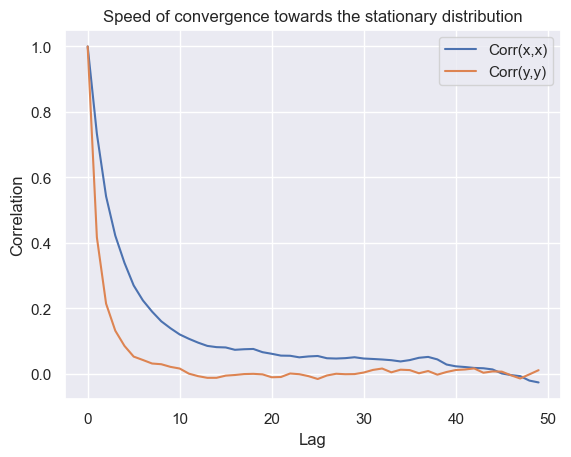

In [12]:
plt.plot(crosscorr(np.array(x_list)[:,0],np.array(x_list)[:,0],max_lag=50),label='Corr(x,x)')
plt.plot(crosscorr(np.array(x_list)[:,1],np.array(x_list)[:,1],max_lag=50),label='Corr(y,y)')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title("Speed of convergence towards the stationary distribution")
plt.legend()
plt.show()


#### On the banana distribution

In [13]:
def log_banana_density(x,d=20,B=0.1):
    """ 
    Banana density

    Parameters
    ----------
    x : array of shape (d,), point at which the density is evaluated
    d : int, dimension of the space
    B : float, parameter of the density

    Returns
    -------
    log_density : float, log density
    """

    assert d>2, "d must be greater than 2"

    return -x[0]**2/200 - 0.5*(x[1]+B*x[0]**2-100*B)**2 - 0.5*np.sum(x[2:]**2)

def banana_density(x,d=20,B=0.1):
    return np.exp(log_banana_density(x,d,B))

In [14]:
z0 = np.random.rand(20)

def delta_fun(j):
    return min(0.1, 1/np.sqrt(j))

x_list, accept_rate, l_list = adaptative_MCMC_w_Gibbs(z0,log_banana_density,delta_fun,maxiter=50000)
print("Number of accepted samples : ",len(x_list))

Number of accepted samples :  247043


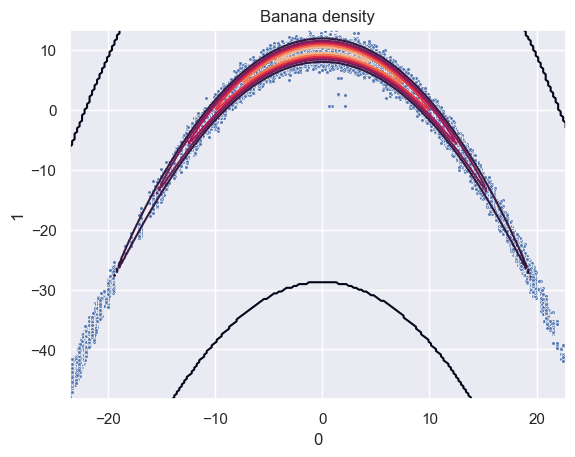

In [15]:
plot_distrib(x_list,None,[banana_density],title="Banana density")

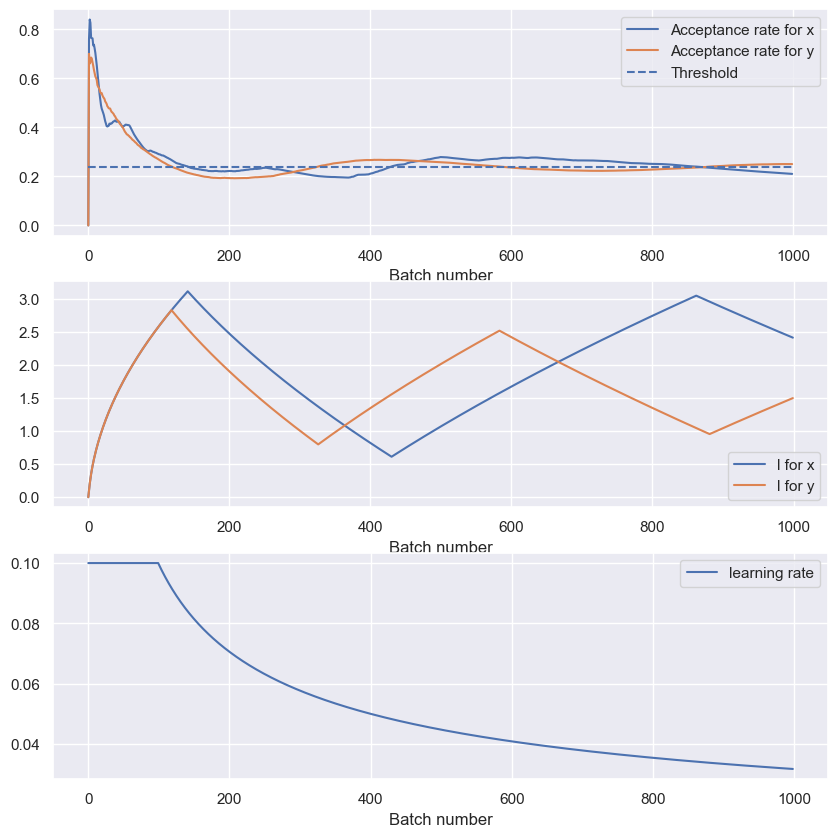

In [16]:
fig, axes = plt.subplots(3,1,figsize=(10,10))

axes[0].plot(accept_rate[:,0],label='Acceptance rate for x')
axes[0].plot(accept_rate[:,1],label='Acceptance rate for y')
axes[0].hlines(0.24,0,accept_rate.shape[0],linestyles='dashed',label='Threshold')
axes[0].legend()
axes[0].set_xlabel('Batch number')

axes[1].plot((l_list[:,0]),label='l for x')
axes[1].plot((l_list[:,1]),label='l for y')
axes[1].legend()
axes[1].set_xlabel('Batch number')

axes[2].plot([delta_fun(j) for j in range(1,len(accept_rate))],label='learning rate')
axes[2].legend()
axes[2].set_xlabel('Batch number')

plt.show()

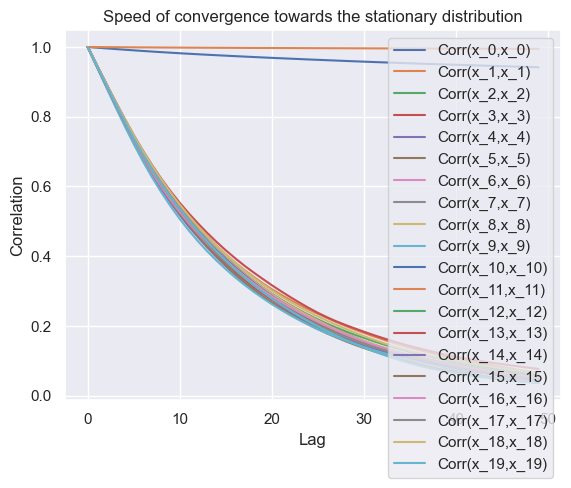

In [17]:
for dim in range(x_list.shape[1]):
    plt.plot(crosscorr(x_list[:,dim],x_list[:,dim],max_lag=50),label='Corr(x_{},x_{})'.format(dim,dim))
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title("Speed of convergence towards the stationary distribution")
plt.legend()
plt.show()


The first two dimensions are correlated because of the shape of the distribution. A random walk doesn't allow for big jumps thus the high correlation.

# Exercise 2

## 2.A – A toy example


### Question 1

In [18]:
mus = np.array([[2.18,5.76],[8.67,9.59],[4.24,8.48],[8.41,1.68],[3.93,8.82],[3.25,3.47],[1.70,0.50],[4.59,5.60],[6.91,5.81],[6.87,5.40],[5.41,2.65],[2.70,7.88],[4.98,3.70],[1.14,2.39],[8.33,9.50],[4.93,1.50],[1.83,0.09],[2.26,0.31],[5.54,6.86],[1.69,8.11]])

def gaussian_mixture(x,mus=mus,sigma=0.1,w=0.05):
    return np.sum([w/(2*np.pi*sigma**2)*np.exp(-np.sum((x-mu)**2)/(2*sigma**2)) for mu in mus])

def log_gaussian_mixture(x,mus=mus,sigma=0.1,w=0.05):
    return np.log(gaussian_mixture(x,mus,sigma,w))

In [19]:
def HM_sampler(z0,pi_fun,sigma_prop,maxiter=1000,verbose=False,ignore_warning=False):
    ''' 
    Hastings-Metropolis sampler

    Parameters
    ----------
    z0 : array of shape (b,), initial value of the Markov chain (here b = 2+2N)
    pi_fun : function, log density
    sigma_prop : float, standard deviation of the proposal distribution
    maxiter : int, number of iterations
    verbose : bool, print acceptance rate

    Returns
    -------
    z_list : list of arrays, accepted values of the Markov chain
    '''

    #Initialisation
    z = z0

    z_list = [z0]

    #Loop
    for i in range(maxiter):
        #Proposal
        z_prop = z + norm.rvs(loc=0, scale=sigma_prop, size=z.shape)

        #Acceptance probability
        log_ratio = min(0,pi_fun(z_prop) - pi_fun(z))

        #Acceptance
        if np.log(np.random.rand()) < log_ratio:
            z = z_prop

            z_list.append(z)

    if verbose:
        print("Acceptance rate: ", len(z_list)/maxiter)
    
    if len(z_list) == 1 and ignore_warning == False:
        print("Warning : no point accepted, decrease sigma_prop")

    return np.array(z_list)

### Question 2

In [20]:
z0 = np.random.rand(2)*10
sigma = 0.1
print("Initial point : ",z0)
x_list = HM_sampler(z0,log_gaussian_mixture,sigma_prop=sigma,maxiter=10000,verbose=True)

Initial point :  [3.65205025 2.82332976]
Acceptance rate:  0.5444


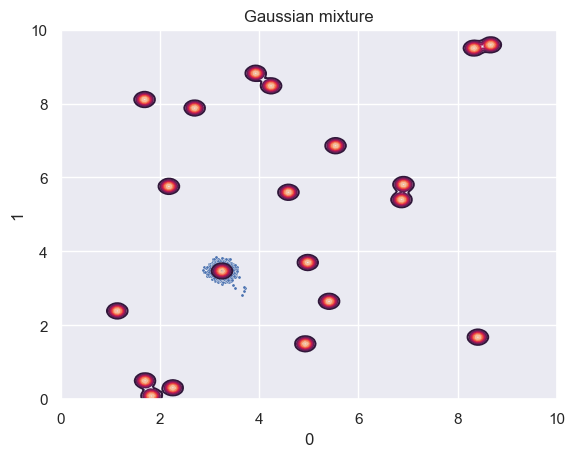

In [21]:
plot_distrib(x_list,None,[gaussian_mixture],range_values=[0,10,0,10],title="Gaussian mixture")

In [22]:
x_list, accept_rate, l_list = adaptative_MCMC_w_Gibbs(z0,log_gaussian_mixture,delta_fun,maxiter=10000)
print("Number of accepted samples : ",len(x_list))

Number of accepted samples :  4859


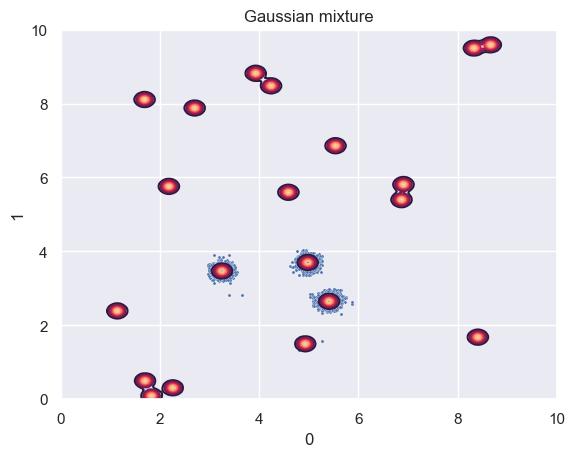

In [23]:
plot_distrib(x_list,None,[gaussian_mixture],range_values=[0,10,0,10],title="Gaussian mixture")

Both method are not able to sample the distribution properly. The sampling relies heavily on the initial value of the chain and then the chain is not able to explore all of the modes.

## 2.B – Parallel Tempering

### Question 1

In [24]:
def parallel_tempering(X_0,pi_fun,T_ladder, N_iter):
    """ 
    Parallel tempering algorithm
    
    Parameters
    ----------
    X_0 : array of shape (K,d), initial value of the Markov chain
    pi_fun : function, target log density, ie at T=1
    T_ladder : list of K floats, temperatures of the chains
    N_iter : int, number of iterations

    Returns
    -------
    X_list : arrayof shape (n_accepted,K,d), accepted values of the Markov chain at different temperatures

    """

    K,d = X_0.shape
    assert K == len(T_ladder), "X_0 and T_ladder must have the same length"

    X_n = np.copy(X_0)

    X_list = [X_0]

    for n in range(N_iter):
        Y_n = np.copy(X_n)
        for i in range(K):
            # Sample Y_n[i] from the proposal distribution using HMRW
            Y_n_0 = np.copy(Y_n[i])
            tau_i = 0.25*np.sqrt(T_ladder[i])
            Y_n[i] = HM_sampler(Y_n_0,lambda x: pi_fun(x)/T_ladder[i],sigma_prop=tau_i,maxiter=5,ignore_warning=True)[-1]
            
        # Choose chains to mix
        i,j = 0,0
        while i == j or np.abs(i-j)!=1:
            i,j = np.random.randint(0,K,size=2)

        # Compute acceptance probability
        pi_i = lambda x: (1/T_ladder[i])*pi_fun(x)
        pi_j = lambda x: (1/T_ladder[j])*pi_fun(x)
        alpha = min(0, pi_i(Y_n[j])+pi_j(Y_n[i])- pi_i(Y_n[i]) - pi_j(Y_n[j]))
        
        # Mix chains
        if np.log(np.random.rand()) <= alpha:
            X_n[i] = Y_n[j]
            X_n[j] = Y_n[i]
        else:
            X_n[i] = Y_n[i]
            X_n[j] = Y_n[j]

        for k in range(K):
            if k != i and k != j:
                X_n[k] = Y_n[k]

        X_list.append(np.copy(X_n))

    return np.array(X_list)


In [25]:
T_ladder =[60,21.6,7.7,2.8,1]
X_0 = np.random.rand(len(T_ladder),2)*10

X_list = parallel_tempering(X_0,log_gaussian_mixture,T_ladder,1000)

C:\Users\Théau Blanchard\AppData\Local\Temp\ipykernel_13644\401984330.py:7: RuntimeWarning: divide by zero encountered in log
  return np.log(gaussian_mixture(x,mus,sigma,w))


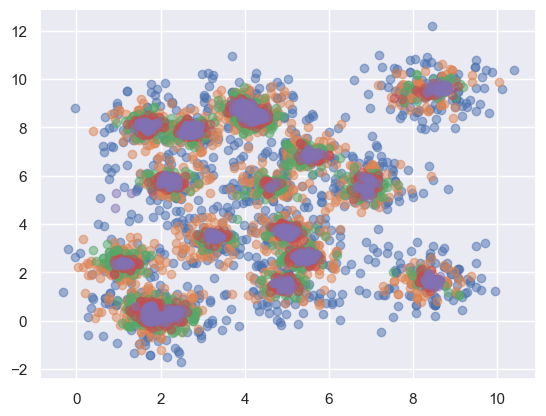

In [26]:
for T in range(len(T_ladder)):
    plt.scatter(X_list[:,T,0],X_list[:,T,1],alpha=0.5)

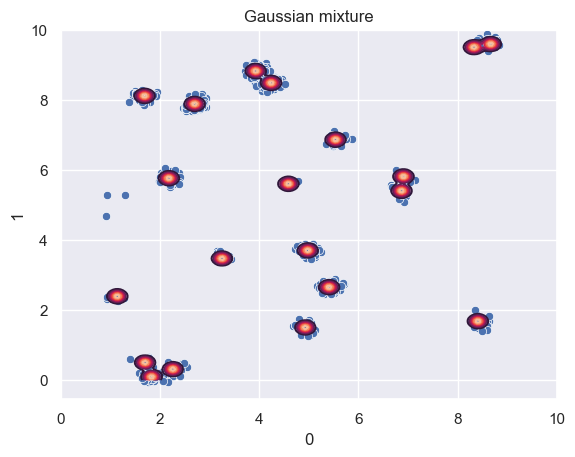

In [27]:
res = X_list[:,-1,:]
plot_distrib(res,None,[gaussian_mixture],range_values=[0,10,0,10],title="Gaussian mixture",marker_size=None)

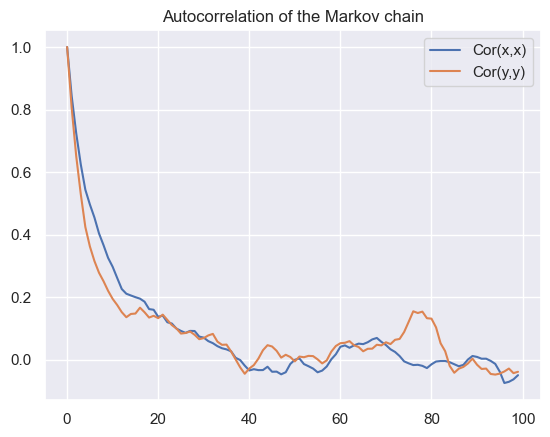

In [28]:
plt.plot(crosscorr(res[:,0],res[:,0],max_lag=100),label="Cor(x,x)")
plt.plot(crosscorr(res[:,1],res[:,1],max_lag=100),label="Cor(y,y)")
plt.legend()
plt.title("Autocorrelation of the Markov chain")
plt.show()

# Exercise 3

# Question 1

Let's compute the a posteriori distribution : $p(X,\mu,\sigma,\tau | Y)$. We have

$$
p(X,\mu,\sigma,\tau | Y) \propto p(Y | X,\mu,\sigma,\tau) p(X | \mu,\sigma,\tau) \pi_{prior}(\sigma,\tau,\mu)
$$

But :
- $$\log(p(Y | X,\mu,\sigma,\tau)) =  -K\log(\tau) - \frac{1}{2\tau^2} \sum_{i=1}^N \sum_{j=1}^{k_i} (y_{i,j}-x_i)^2 $$
- $$\log(p(X | \mu,\sigma,\tau)) =  -N\log(\sigma) - \frac{1}{2\sigma^2} \sum_{i=1}^N \sum_{j=1}^{k_i} (x_i-\mu)^2 $$
- $$\log(\pi_{prior}(\sigma,\tau,\mu)) = -\beta(\sigma^{-2}+\tau^{-2}) -2(1+\alpha)\log(\sigma) - 2(1+\gamma)\log(\tau) $$

So finally, we have
$$
\log(p(X,\mu,\sigma,\tau | Y)) \propto -(K+2\alpha+2)\log(\tau) -(N+2\gamma+2)\log(\sigma)  -\beta(\sigma^{-2}+\tau^{-2}) - \frac{1}{2\tau^2} \sum_{i=1}^N \sum_{j=1}^{k_i} (y_{i,j}-x_i)^2  - \frac{1}{2\sigma^2} \sum_{i=1}^N \sum_{j=1}^{k_i} (x_i-\mu)^2
$$

We have to compute the condiitonnal distribution for each variable for the Gibbs sampler. We have :
$$
p(X) \propto \prod_{i=1}^N \exp \left(  -\frac{1}{2\tau^2}\sum_{j=1}^{k_i} (y_{i,j}-x_i)^2 - \frac{1}{2\sigma^2}(x_i-\mu)^2   \right)
$$
Hence $$X_i \sim \mathcal{N}(\frac{\tau^2\mu+\sigma^2 \sum_{j=1}^{k_i} y_{i,j}}{k_i \sigma^2+\tau^2},\frac{\sigma^2\tau^2}{k_i \sigma^2+\tau^2})$$

We have :
$$
p(\mu) \propto \exp \left(  - \frac{1}{2\sigma^2}\sum_{i=}^N(x_i-\mu)^2   \right)
$$

Hence $$\mu \sim \mathcal{N}(\frac{1}{N} \sum_{i=1}^N x_i,\frac{\sigma^2}{N})$$

Also we have :

$$
\tau \sim \text{InvGamma}(\gamma + \frac{K}{2}, \beta + \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^{k_i} (y_{i,j}-x_i)^2)
$$
And
$$
\sigma \sim \text{InvGamma}(\alpha + \frac{N}{2}, \beta + \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^{k_i} (x_i-\mu)^2)

In [29]:
# Fixed hyperparameters
alpha = 0.05
beta =  0.05
gamma = 0.05

# We consider the same number of sample per observation
k = 100
N = 50
K = N*k

## Question 2

In [30]:
def Gibbs_sampler(Y , sigma0, tau0 , mu0 , X0 , beta , alpha , gamma , N, k , num_samples,discard_ratio = 0.4) : 
    
    # Initiate Variables 
    sigma_list = []
    sigma_ = sigma0
    tau_list = []
    tau_ = tau0
    mu_list = []
    mu_ = mu0 
    X_list = []
    X_ = X0
    
    for i in range(num_samples):
        
        # Sample from distributions
        sigma_new = 1 / np.random.gamma(shape= N/2 + alpha , scale=1/(beta + np.sum((X_- mu_)**2)/2))
        tau_new = 1 / np.random.gamma(shape= N*k/2 + gamma , scale=1/(beta + np.sum((Y.T - X_)**2)/2))
        mu_new = np.random.normal(loc = np.mean(X_), scale=np.sqrt(sigma_/N))
        
        X_new = np.zeros(N)
        for j in range(N): 
            l = (tau_ * mu_ + sigma_*np.sum(Y[j,:]))/(k * sigma_ + tau_)
            s = np.sqrt((sigma_*tau_)/(k * sigma_ + tau_))
            X_new[j] = np.random.normal(loc = l ,scale= s) 
        
        sigma_list.append(sigma_new)
        tau_list.append(tau_new)
        mu_list.append(mu_new)
        X_list.append(X_new)
        
        sigma_ = sigma_new
        tau_ = tau_new
        mu_ = mu_new
        X_ = X_new

    # Discard burn-in samples
    sigma_list = sigma_list[int(discard_ratio*num_samples):]
    tau_list = tau_list[int(discard_ratio*num_samples):]
    mu_list = mu_list[int(discard_ratio*num_samples):]
    X_list = X_list[int(discard_ratio*num_samples):]
    
    
    return np.array(sigma_list), np.array(tau_list), np.array(mu_list), np.array(X_list)


## Question 3

First we need to compute the conditionnal distribution of $p(X,\mu)$. We have :

\begin{align*} 
P(X,\mu|Y,\sigma^2,\tau^2) 
&\propto \prod_{i=1}^N  exp(-\frac{\sum_{j}^{k_i} (y_{i,j}-X_i)^2}{2\tau^2} -\frac{(X_i-\mu)^2}{2\sigma^2}) \\
&\propto \prod_{i=1}^N  exp( -\frac{\sum_{j}^{k_i} (y_{i,j}^2 -2 y_{i,j} X_i + X_i^2)}{2\tau^2} -\frac{(X_i^2 -2\mu X_i + \mu^2)}{2\sigma^2}) \\
& \propto \prod_{i=1}^N exp(-\frac{1}{2}(\frac{(\sigma^2 k_i + \tau^2)X_i^2}{\tau^2 \sigma^2} -\frac{2 \sum_{j=1}^{k_i} y_{i,j} Xi}{\tau^2}-\frac{2X_i\mu}{\sigma^2}+\frac{\mu^2}{\sigma^2}))
\end{align*}

Hence if we set :
$Cov = 
\begin{pmatrix}
\frac{\sigma^2 k + \tau^2}{\tau^2 \sigma^2} & 0  & 0 & \frac{-1}{\sigma^2} \\
0 & \ddots &  0 & \vdots \\
0 & 0  & \frac{\sigma^2 k + \tau^2}{\tau^2 \sigma^2} & \frac{-1}{\sigma^2} \\
\frac{-1}{\sigma^2}  & \cdots  &  \frac{-1}{\sigma^2}  &  \frac{N}{\sigma^2} \\
\end{pmatrix}$

And $\mathbf{\mu}= cov \times \begin{pmatrix}
\frac{\sum_{j=1}^{k} y_{i,j}}{\tau^2} & \cdots & \frac{\sum_{j=1}^{k} y_{i,j}}{\tau^2} \\
\end{pmatrix}$ 

We have that $(X,\mu)$ follows a multivariate gaussian distribution

$$(X,\mu) \sim \mathcal{N}(\mathbf{\mu},Cov)$$

In [31]:
def block_Gibbs_sampler(Y , sigma0, tau0 , mu0 , X0 , beta , alpha , gamma , N, k , num_samples,discard_ratio =0.5) : 
    
    # Initiate Variables 
    sigma_list = []
    sigma_ = sigma0
    tau_list = []
    tau_ = tau0
    mu_list = []
    mu_ = mu0 
    X_list = []
    X_ = X0

    Y_ = np.zeros(N+1)
    Y_[:N] = np.sum(Y, axis = 1).reshape(N)
    
    for i in range(num_samples):
        
        # Sample from distributions
        sigma_new = 1 / np.random.gamma(shape= N/2 + alpha , scale=1/(beta + np.sum((X_- mu_)**2)/2))
        tau_new = 1 / np.random.gamma(shape= N*k/2 + gamma , scale=1/(beta + np.sum((Y.T - X_)**2)/2))
        mu_new = np.random.normal(loc = np.mean(X_), scale=np.sqrt(sigma_/N))
        
        cov = np.zeros((N+1,N+1))
        diag_idx = np.diag_indices(N+1)
        cov[diag_idx] = (k*sigma_ + tau_)/(sigma_* tau_)
        cov[:,N]= -1/sigma_
        cov[N,:] = -1/sigma_
        cov[N,N] = N/sigma_

        mean = cov@Y_/tau_

        prop = np.random.multivariate_normal(mean=mean, cov=np.linalg.pinv(cov),size=1).reshape(N+1)
        X_new=prop[:N]
        mu_new=prop[-1]
        
        sigma_list.append(sigma_new)
        tau_list.append(tau_new)
        mu_list.append(mu_new)
        X_list.append(X_new)
        
        sigma_ = sigma_new
        tau_ = tau_new
        mu_ = mu_new
        X_ = X_new

    sigma_list = sigma_list[int(discard_ratio*num_samples):]
    tau_list = tau_list[int(discard_ratio*num_samples):]
    mu_list = mu_list[int(discard_ratio*num_samples):]
    X_list = X_list[int(discard_ratio*num_samples):]
    
    return np.array(sigma_list), np.array(tau_list), np.array(mu_list), np.array(X_list)


## Question 4

Block Gibbs sampler is sometimes used instead of the regular Gibbs sampler. First when the number of variable is too important, it can become expensive to sample each variable one at a time. Thus sampling the variable by block can be more efficient. Then if the variables are highly correlated, sampling them sequentially one at a time can lead to a poor mixing of the chain and to a high autocorrelation. In this case, sampling the variables by block can lead to a better mixing of the chain.

## Question 5

In [32]:
# Target values
mu_true = 5.
sigma_true = 3.
tau_true = 1.75

# Initial values
mu_0 = 0.1
sigma_0 = 1.
tau_0 = 1.

In [33]:
epsilon = norm.rvs(loc=0, scale=np.sqrt(tau_true), size=(N,k))
X = norm.rvs(loc=mu_true, scale=np.sqrt(sigma_true), size=N)
Y = X[:,None] + epsilon

X_0 = np.zeros_like(X)

In [37]:
sigma_list, tau_list , mu_list, X_list = Gibbs_sampler(Y , sigma_0, tau_0 , mu_0 , X_0 , beta , alpha , gamma , N, k , 5000) 
# sigma_list, tau_list , mu_list, X_list = block_Gibbs_sampler(Y , sigma_0, tau_0 , mu_0 , X_0 , beta , alpha , gamma , N, k , 5000) 

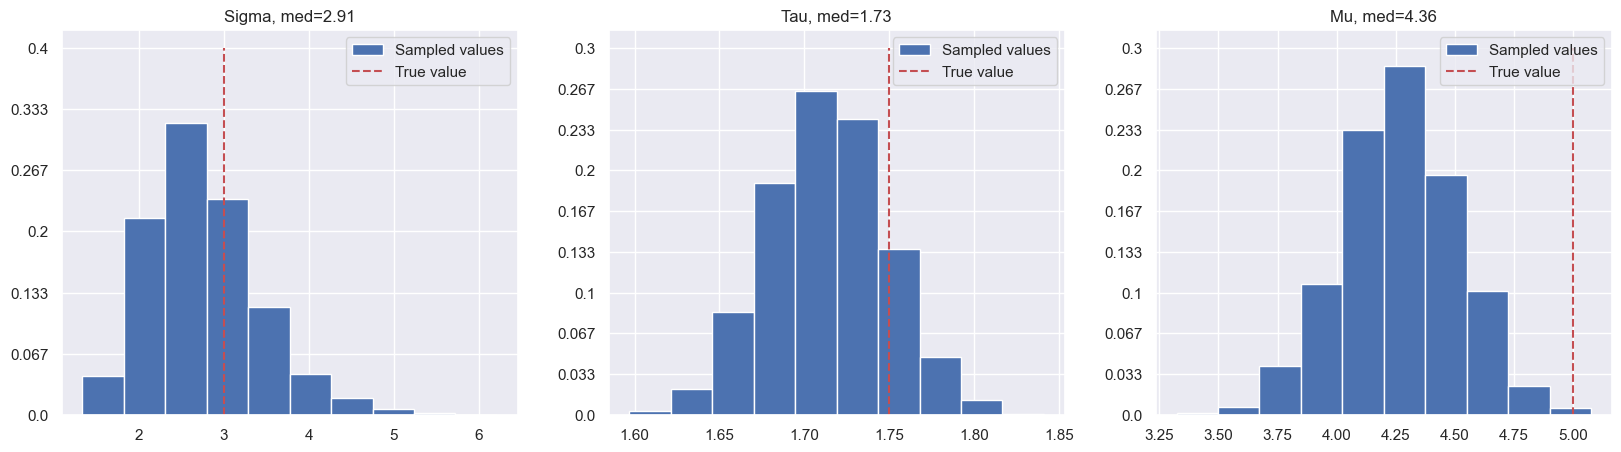

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].hist(sigma_list, density=False,label='Sampled values',align='left')
locs = ax[0].get_yticks() 
ax[0].set_yticks(locs,np.round(locs/len(sigma_list),3))
ax[0].vlines(sigma_true, 0, np.max(locs), color='r', linestyle='--', label='True value')
ax[0].legend()
ax[0].set_title(f"Sigma, med={np.median(sigma_list):0.2f}")

ax[1].hist(tau_list, density=False,label='Sampled values',align='left')
locs = ax[1].get_yticks()
ax[1].set_yticks(locs,np.round(locs/len(tau_list),3))
ax[1].vlines(tau_true, 0, np.max(locs), color='r', linestyle='--', label='True value')
ax[1].legend()
ax[1].set_title(f"Tau, med={np.median(tau_list):0.2f}")

ax[2].hist(mu_list, density=False,label='Sampled values',align='left')
locs = ax[2].get_yticks()
ax[2].set_yticks(locs,np.round(locs/len(mu_list),3))
ax[2].vlines(mu_true, 0, np.max(locs), color='r', linestyle='--', label='True value')
ax[2].legend()
ax[2].set_title(f"Mu, med={np.median(mu_list):0.2f}")

plt.show()

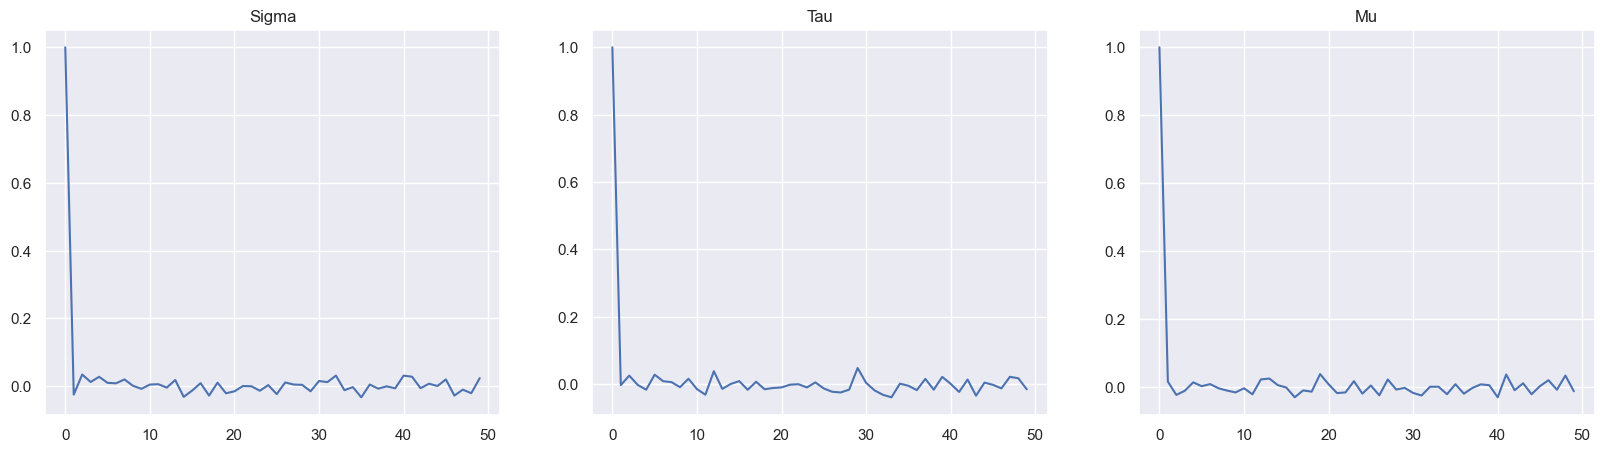

In [39]:
# Plot the autotocorrelation of the sampled values

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(crosscorr(sigma_list,sigma_list,50))
ax[0].set_title("Sigma")

ax[1].plot(crosscorr(tau_list,tau_list,50))
ax[1].set_title("Tau")

ax[2].plot(crosscorr(mu_list,mu_list,50))
ax[2].set_title("Mu")

plt.show()
